In [33]:
import pandas as pd
import numpy as np

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.naive_bayes import ComplementNB
import pickle

from sklearn.metrics import confusion_matrix,f1_score,roc_auc_score,roc_curve
import matplotlib.pyplot as plt
%matplotlib inline

# data

In [27]:
df = pd.read_csv('Processed_data/clean_data.csv',index_col=0)

In [3]:
df.head()

,claim_id,enrollee_id,provider_id,provider_status,hmo_id,care_id,qty,amount,approved_qty,approved_amount,hmo_approved,created_at,vetted_at,label,unit_price
0,10.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-12 14:53:46,2018-05-21 10:05:30,0,302.68
1,11.0,89.0,1.0,1.0,1.0,586.0,6.0,1816.08,6.0,1816.08,1.0,2018-03-13 14:50:39,2018-05-21 10:07:19,0,302.68
2,13.0,74.0,1.0,1.0,1.0,434.0,5.0,115.00,5.0,115.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,23.00
3,13.0,74.0,1.0,1.0,1.0,1102.0,10.0,1265.00,10.0,1265.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,126.50
4,13.0,74.0,1.0,1.0,1.0,299.0,15.0,138.00,15.0,138.00,1.0,2018-03-16 10:28:53,2018-05-21 10:09:30,0,9.20


In [34]:
X = df[['enrollee_id','provider_id','provider_status','hmo_id','care_id','qty','unit_price']]
y = df['label']
Xtrain,Xtest,ytrain,ytest = train_test_split(X.values,y.values,test_size = 0.2,random_state=0)


In [29]:
def init_scores():
    
    global scores 
    scores = {}
    scores['f1_socre'] = []
    scores['precision'] = []
    scores['recall'] = []
    scores['FPR'] = []
    scores['specificity'] = []
    scores['roc_auc'] = []
    
    return scores


def evaluation(ytest,Xtest,cls):
    global scores
    scores = init_scores()
    ypred = cls.predict(Xtest)
    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))
    
    
def cv(Xtrain,ytrain,model):
    global scores
    models = []
    kf = KFold(n_splits=4)
    print(model)
    n = 0
    for train_index, test_index in kf.split(Xtrain):
        print('cross_validate_run: {}'.format(n))
        Xtr, Xte = Xtrain[train_index], Xtrain[test_index]
        ytr, yte = ytrain[train_index], ytrain[test_index]
        cls = model.fit(Xtr, ytr) 
        models.append(cls)
        evaluation(yte,Xte,cls)
        n += 1
    
    print('\n mean scores +/- sd: \n')
    for k in scores:
        print('{} : {:0.3f} +/- {:0.3f}'.format(k, np.array(scores[k]).mean(),  np.array(scores[k]).std()))
        
    scores = init_scores()
    return models

# naive bayes

In [35]:

model_nb = ComplementNB()
models_nb = cv(Xtrain,ytrain,model_nb)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.103
precision: 0.059
recall/sensitivity(true positive rate): 0.401
false positive rate (FPR): 0.329
spcificity(true negative rate): 0.671
ROC_AUC_score: 0.536
cross_validate_run: 1
f1_socre: 0.108
precision: 0.063
recall/sensitivity(true positive rate): 0.394
false positive rate (FPR): 0.313
spcificity(true negative rate): 0.687
ROC_AUC_score: 0.540
cross_validate_run: 2
f1_socre: 0.106
precision: 0.061
recall/sensitivity(true positive rate): 0.396
false positive rate (FPR): 0.311
spcificity(true negative rate): 0.689
ROC_AUC_score: 0.543
cross_validate_run: 3
f1_socre: 0.109
precision: 0.063
recall/sensitivity(true positive rate): 0.386
false positive rate (FPR): 0.306
spcificity(true negative rate): 0.694
ROC_AUC_score: 0.540

 mean scores +/- sd: 

f1_socre : 0.109 +/- 0.000
precision : 0.063 +/- 0.000
recall : 0.386 +/- 0.000
FPR : 0.306 +/- 0.000
specificity : 0.694 +/- 0.000
ro

In [36]:
evaluation(ytest,Xtest,models_nb[2])

f1_socre: 0.100
precision: 0.058
recall/sensitivity(true positive rate): 0.372
false positive rate (FPR): 0.306
spcificity(true negative rate): 0.694
ROC_AUC_score: 0.533


In [37]:
pickle.dump(models_nb[2],open("Models/xgb_nb.dat", "wb"))

# lightGBM no_upsampling

In [30]:
model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=100, max_depth=15, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:100}, \
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                       random_state=None, n_jobs=3, silent=True, importance_type='split')
models_lgb = cv(Xtrain,ytrain,model_lgb)

LGBMClassifier(boosting_type='gbdt', class_weight={1: 100},
               colsample_bytree=1.0, importance_type='split', learning_rate=0.1,
               max_depth=15, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=300, n_jobs=3, num_leaves=100,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.195
precision: 0.111
recall/sensitivity(true positive rate): 0.825
false positive rate (FPR): 0.341
spcificity(true negative rate): 0.659
ROC_AUC_score: 0.742
cross_validate_run: 1
f1_socre: 0.200
precision: 0.114
recall/sensitivity(true positive rate): 0.823
false positive rate (FPR): 0.340
spcificity(true negative rate): 0.660
ROC_AUC_score: 0.742
cross_validate_run: 2
f1_socre: 0.193
precision: 0.109
recall/sensitivity(true positive rate): 0.823
false positive rate (FPR): 0.342
sp

In [22]:
model_lgb = LGBMClassifier(boosting_type='gbdt', num_leaves=100, max_depth=10, learning_rate=0.1, \
                       n_estimators=300, subsample_for_bin=200000, objective=None, class_weight={1:50}, \
                       min_split_gain=0.0, min_child_weight=0.001, min_child_samples=20, subsample=1.0, \
                       subsample_freq=0, colsample_bytree=1.0, reg_alpha=0.0, reg_lambda=0.0, \
                       random_state=None, n_jobs=3, silent=True, importance_type='split')
models_lgb = cv(Xtrain,ytrain,model_lgb)

LGBMClassifier(boosting_type='gbdt', class_weight={1: 50}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=10,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=3, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.216
precision: 0.125
recall/sensitivity(true positive rate): 0.796
false positive rate (FPR): 0.288
spcificity(true negative rate): 0.712
ROC_AUC_score: 0.754
cross_validate_run: 1
f1_socre: 0.225
precision: 0.131
recall/sensitivity(true positive rate): 0.805
false positive rate (FPR): 0.285
spcificity(true negative rate): 0.715
ROC_AUC_score: 0.760
cross_validate_run: 2
f1_socre: 0.214
precision: 0.123
recall/sensitivity(true positive rate): 0.791
false positive rate (FPR): 0.286
spcificity(true ne

# xgboost-no_upsampling_with_scale

In [19]:

model_xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)

In [20]:
cv(Xtrain,ytrain,model_xgb)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.338
precision: 0.266
recall/sensitivity(true positive rate): 0.464
false positive rate (FPR): 0.066
spcificity(true negative rate): 0.934
ROC_AUC_score: 0.699
cross_validate_run: 1
f1_socre: 0.346
precision: 0.275
recall/sensitivity(true positive rate): 0.465
false positive rate (FPR): 0.065
spcificity(true negative rate): 0.935
ROC_AUC_score: 0.700
cross_validate_run: 2
f1_socre: 0.335
precision: 0.264
recall/sensitivity(true positive rate): 0.460
false positive rate (FPR): 0.065
spcifici

[XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=15,
               min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
               silent=None, subsample=1, verbosity=1),
 XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
               colsample_bynode=1, colsample_bytree=1, gamma=0,
               learning_rate=0.1, max_delta_step=0, max_depth=15,
               min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
               nthread=None, objective='binary:logistic', random_state=0,
               reg_alpha=0, reg_lambda=1, scale_pos_weight=19, seed=None,
               silent=None, subsample=1, verbosity=1),
 XGBClassifier(base_score=0.5, booster='

# upsampling
## llightGBM

In [38]:
Xy = X.copy()
Xy['y'] = y

class0 = Xy.loc[Xy.y == 0]
class1 = Xy.loc[Xy.y == 1]
print(class0.shape,class1.shape)
class1 = class1.sample(n=class0.shape[0],replace=True,random_state=0)
Xy = pd.concat([class0,class1])
yup = Xy['y']
Xup = Xy.drop(columns=['y'])
# re-do train_test split of balanced data
Xuptrain,Xuptest,yuptrain,yuptest = train_test_split(Xup.values,yup.values,test_size = 0.2,random_state=42)

(268137, 8) (13914, 8)


In [26]:

# lightgmb with class weight
model_lgb_up_sc = LGBMClassifier(boosting_type='gbdt', class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=3, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

models_up_sc = cv(Xuptrain,yuptrain,model_lgb_up_sc)

(268137, 8) (13914, 8)
LGBMClassifier(boosting_type='gbdt', class_weight={1: 2}, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=3, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.868
precision: 0.784
recall/sensitivity(true positive rate): 0.973
false positive rate (FPR): 0.268
spcificity(true negative rate): 0.732
ROC_AUC_score: 0.852
cross_validate_run: 1
f1_socre: 0.869
precision: 0.784
recall/sensitivity(true positive rate): 0.974
false positive rate (FPR): 0.270
spcificity(true negative rate): 0.730
ROC_AUC_score: 0.852
cross_validate_run: 2
f1_socre: 0.869
precision: 0.786
recall/sensitivity(true positive rate): 0.972
false positive rate (FPR): 0.

In [31]:
evaluation(yuptest,Xuptest,models_up_sc[3])

f1_socre: 0.868
precision: 0.783
recall/sensitivity(true positive rate): 0.973
false positive rate (FPR): 0.269
spcificity(true negative rate): 0.731
ROC_AUC_score: 0.852


In [39]:
# without class weight
model_lgb_up = LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=3, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
models_up = cv(Xuptrain,yuptrain,model_lgb_up)

LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=15,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=300, n_jobs=3, num_leaves=100, objective=None,
               random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
cross_validate_run: 0
f1_socre: 0.872
precision: 0.848
recall/sensitivity(true positive rate): 0.897
false positive rate (FPR): 0.161
spcificity(true negative rate): 0.839
ROC_AUC_score: 0.868
cross_validate_run: 1
f1_socre: 0.871
precision: 0.848
recall/sensitivity(true positive rate): 0.896
false positive rate (FPR): 0.162
spcificity(true negative rate): 0.838
ROC_AUC_score: 0.867
cross_validate_run: 2
f1_socre: 0.871
precision: 0.845
recall/sensitivity(true positive rate): 0.899
false positive rate (FPR): 0.165
spcificity(true negat

In [34]:
evaluation(yuptest,Xuptest,models_up[3])

f1_socre: 0.874
precision: 0.846
recall/sensitivity(true positive rate): 0.904
false positive rate (FPR): 0.164
spcificity(true negative rate): 0.836
ROC_AUC_score: 0.870


In [40]:
pickle.dump(models_up[3],open("Models/xgb_lgb_up.dat", "wb"))

## xgboost

In [32]:
# without scale positive class
model_xgb_up = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
models_up_xgb = cv(Xuptrain,yuptrain,model_xgb_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.954
precision: 0.919
recall/sensitivity(true positive rate): 0.991
false positive rate (FPR): 0.087
spcificity(true negative rate): 0.913
ROC_AUC_score: 0.952
cross_validate_run: 1
f1_socre: 0.952
precision: 0.917
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.091
spcificity(true negative rate): 0.909
ROC_AUC_score: 0.950
cross_validate_run: 2
f1_socre: 0.953
precision: 0.916
recall/sensitivity(true positive rate): 0.992
false positive rate (FPR): 0.090
spcificit

In [35]:
evaluation(yuptest,Xuptest,models_up_xgb[0])

f1_socre: 0.951
precision: 0.914
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.092
spcificity(true negative rate): 0.908
ROC_AUC_score: 0.949


In [28]:
# with scale positive class
model_xgb_up_sc = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)
models_up_xgb_sc = cv(Xuptrain,yuptrain,model_xgb_up)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=15,
              min_child_weight=1, missing=None, n_estimators=300, n_jobs=4,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=2, seed=None,
              silent=None, subsample=1, verbosity=1)
cross_validate_run: 0
f1_socre: 0.947
precision: 0.901
recall/sensitivity(true positive rate): 0.999
false positive rate (FPR): 0.110
spcificity(true negative rate): 0.890
ROC_AUC_score: 0.944
cross_validate_run: 1
f1_socre: 0.947
precision: 0.899
recall/sensitivity(true positive rate): 0.999
false positive rate (FPR): 0.112
spcificity(true negative rate): 0.888
ROC_AUC_score: 0.943
cross_validate_run: 2
f1_socre: 0.945
precision: 0.896
recall/sensitivity(true positive rate): 0.999
false positive rate (FPR): 0.116
spcificit

In [29]:
evaluation(yuptest,Xuptest,models_up_xgb_sc[0])

f1_socre: 0.944
precision: 0.896
recall/sensitivity(true positive rate): 0.998
false positive rate (FPR): 0.116
spcificity(true negative rate): 0.884
ROC_AUC_score: 0.941


In [38]:
evaluation(yuptest,Xuptest,models_up_xgb[0])

f1_socre: 0.951
precision: 0.914
recall/sensitivity(true positive rate): 0.990
false positive rate (FPR): 0.092
spcificity(true negative rate): 0.908
ROC_AUC_score: 0.949


In [39]:
pickle.dump(models_up_xgb[0],open("Models/xgb_up_tree15.dat", "wb"))

In [36]:
from sklearn.naive_bayes import ComplementNB
model1 = ComplementNB()
models_nb = cv(Xuptrain,yuptrain,model1)
evaluation(yuptest,Xuptest,models_nb[0])

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)
cross_validate_run: 0
f1_socre: 0.450
precision: 0.551
recall/sensitivity(true positive rate): 0.380
false positive rate (FPR): 0.310
spcificity(true negative rate): 0.690
ROC_AUC_score: 0.535
cross_validate_run: 1
f1_socre: 0.457
precision: 0.559
recall/sensitivity(true positive rate): 0.387
false positive rate (FPR): 0.308
spcificity(true negative rate): 0.692
ROC_AUC_score: 0.540
cross_validate_run: 2
f1_socre: 0.451
precision: 0.550
recall/sensitivity(true positive rate): 0.383
false positive rate (FPR): 0.312
spcificity(true negative rate): 0.688
ROC_AUC_score: 0.535
cross_validate_run: 3
f1_socre: 0.453
precision: 0.554
recall/sensitivity(true positive rate): 0.383
false positive rate (FPR): 0.308
spcificity(true negative rate): 0.692
ROC_AUC_score: 0.538

 mean scores +/- sd: 

f1_socre : 0.453 +/- 0.000
precision : 0.554 +/- 0.000
recall : 0.383 +/- 0.000
FPR : 0.308 +/- 0.000
specificity : 0.692 +/- 0.000
ro

# plot performance
## plot scores

In [2]:

f1_score =  [ 
    0.108,
0.249,
0.451,
0.951,
0.874,
0.944,
0.868,
]

sensitivity = [
     0.404,
0.715,
0.381,
0.990,
0.904,
0.998,
0.973,
]

specificity = [
     0.689,
0.793,
0.691,
0.908,
0.836,
0.884,
0.731,
]

roc_auc = [
     0.547,
0.754,
0.536,
0.949,
0.870,
0.941,
0.852,
]

models = [
    
     'NB',
'XGB',
'NB_up',
'XGB_up',
'LGB_up',
'XGB_up_w',
'LGB_up_w',

]

<BarContainer object of 7 artists>

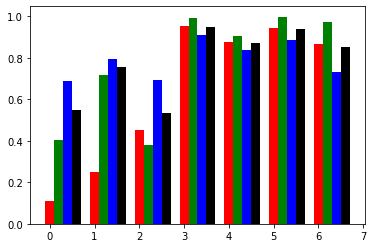

In [50]:
w = 0.2
x = np.array([0,1,2,3,4,5,6])

plt.bar(x,f1_score, label = 'f1_score',color = 'r',width=w)
plt.bar(x+w, sensitivity, label = 'sensitivity',color = 'g',width=w)
plt.bar(x+2*w, specificity, label = 'specificity',color = 'b',width=w)
plt.bar(x+3*w, roc_auc,label = 'auc_roc',color='black',width=w)

In [3]:
nb = [ 0.108,
0.404,
0.689,
0.547
]
xgb = [ 0.249,
0.715,
0.793,
0.754
]
nb_up = [ 0.451,
0.381,
0.691,
0.536
]
xgb_up = [ 0.951,
0.990,
0.908,
0.949
]
lgb_up = [ 0.874,
0.904,
0.836,
0.870,
]
xgb_up_w = [ 0.944,
0.998,
0.884,
0.941
]
lgb_up_w = [ 0.868,
0.973,
0.731,
0.852
]

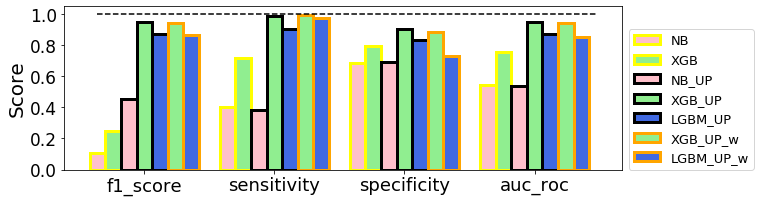

In [66]:
fig = plt.figure(figsize=(10,3))
w = 0.12
x = np.array([0,1,2,3])

plt.bar(x,nb, label = 'NB',color = 'pink',width=w, edgecolor = 'yellow',linewidth=3)
plt.bar(x+w, xgb, label = 'XGB',color = 'lightgreen',width=w,edgecolor = 'yellow',linewidth=3)
plt.bar(x+2*w, nb_up, label = 'NB_UP',color = 'pink',width=w,edgecolor = 'black',linewidth=3)
plt.bar(x+3*w, xgb_up,label = 'XGB_UP',color='lightgreen',width=w,edgecolor = 'black',linewidth=3)
plt.bar(x+4*w, lgb_up,label = 'LGBM_UP',color='royalblue',width=w,edgecolor = 'black',linewidth=3)
plt.bar(x+5*w, xgb_up_w,label = 'XGB_UP_w',color='lightgreen',width=w,edgecolor = 'orange',linewidth=3)
plt.bar(x+6*w, lgb_up_w,label = 'LGBM_UP_w',color='royalblue',width=w,edgecolor = 'orange',linewidth=3)
plt.hlines(1,0,3+7*w,linestyles='dashed')
plt.xticks(x+3*w,['f1_score','sensitivity','specificity','auc_roc'],fontsize=18)
plt.yticks(fontsize=17)
plt.ylabel('Score',fontsize=20)
plt.legend(bbox_to_anchor=(1, 0.9), fontsize=13)#prop=dict(weight='bold')

## verify baseline by random predict

In [75]:
def predict_rand(ytest,ypred):
    global scores
    scores = init_scores()

    C = confusion_matrix(ytest,ypred)
    TN = C[0][0]
    FN = C[1][0]
    TP = C[1][1]
    FP = C[0][1]

    print('f1_socre: {:0.3f}'.format(f1_score(ytest,ypred)))
    scores['f1_socre'].append(f1_score(ytest,ypred))
    print('precision: {:0.3f}'.format(TP/(TP+FP)))
    scores['precision'].append(TP/(TP+FP))
    print('recall/sensitivity(true positive rate): {:0.3f}'.format(TP/(TP+FN)))
    scores['recall'].append(TP/(TP+FN))
    print('false positive rate (FPR): {:0.3f}'.format(1-(TN/(TN+FP)))) # 1 - specificity
    scores['FPR'].append(1-(TN/(TN+FP)))
    print('spcificity(true negative rate): {:0.3f}'.format(TN/(TN+FP)))
    scores['specificity'].append(TN/(TN+FP))
    print('ROC_AUC_score: {:0.3f}'.format(roc_auc_score(ytest,ypred)))
    scores['roc_auc'].append(roc_auc_score(ytest,ypred))
    


In [81]:
# baseline for 5% positive
unbalanced = (np.random.rand(len(yuptest)) < 0.05).astype(int)
predict_rand(yuptest,unbalanced)

f1_socre: 0.091
precision: 0.506
recall/sensitivity(true positive rate): 0.050
false positive rate (FPR): 0.049
spcificity(true negative rate): 0.951
ROC_AUC_score: 0.501


In [82]:
# baseline with balanced class
balanced = (np.random.rand(len(yuptest)) < 0.5).astype(int)
predict_rand(yuptest,balanced)

f1_socre: 0.497
precision: 0.496
recall/sensitivity(true positive rate): 0.498
false positive rate (FPR): 0.504
spcificity(true negative rate): 0.496
ROC_AUC_score: 0.497


## plot ROC_curves

In [41]:
model_xgb = pickle.load(open("Models/xgb_up_tree15.dat", "rb"))
model_nb = models_nb[2]
model_lgb = models_up[3]

In [45]:
xbg_curve = roc_curve(yuptest,model_xgb.predict_proba(Xuptest)[:,1])

In [46]:
nb_curve = roc_curve(yuptest,model_nb.predict_proba(Xuptest)[:,1])
lgb_curve = roc_curve(yuptest,model_lgb.predict_proba(Xuptest)[:,1])

In [55]:
def plot_roc_curves(curves,colors,labels):
    plt.plot([0,0.5,1],[0,0.5,1], linestyle='--', color = 'black') # default classification bound
    
    for i in range(len(curves)):
        fpr, tpr, _ = curves[i]
        plt.plot(fpr,tpr,color=colors[i],linewidth=2,label=labels[i])
    
    plt.xlabel('False Positive Rate',fontsize=20)
    plt.ylabel('True Positive Rate',fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.legend(fontsize=18)

    plt.show()
    

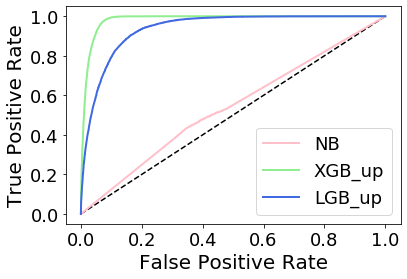

In [56]:
plot_roc_curves([nb_curve,xbg_curve,lgb_curve],['pink','lightgreen','royalblue'],['NB','XGB_up','LGB_up'])